In [3]:
!pip install torch==1.6.0
!pip install opencv-python
!pip install torchvision==0.2.2
!pip install albumentations
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 748.8 MB 16 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.5 MB 29.4 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 5.6 MB/s 
     |████████████████████████████████| 52 kB 3.7 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user i

In [24]:
!pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 669 kB 10.9 MB/s 
     |████████████████████████████████| 98 kB 11.4 MB/s 
     |████████████████████████████████| 10.6 MB 10.3 MB/s 
     |████████████████████████████████| 69 kB 4.4 MB/s 
     |████████████████████████████████| 779 kB 22.6 MB/s 
     |████████████████████████████████| 114 kB 25.7 MB/s 
     |████████████████████████████████| 155 kB 64.5 MB/s 
     |████████████████████████████████| 47 kB 5.5 MB/s 
     |████████████████████████████████| 147 kB 34.4 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import cv2
import matplotlib.pyplot as plt
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
from pytorch_lightning import Trainer
# import resnest.torch as resnest_torch

from torchvision import models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as albu

from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## util

In [2]:
config_set = {
    'dataset': {
          'name': 'SpectrogramDataset',
          'params': {
            'img_size': 224, 
            'melspectrogram_parameters': {
              'n_mels': 128, 
              'fmin': 50, 
              'fmax': 15000, 
            }
      }
    },
    'loader': {
      'train': {
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 2,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}
SEED=100
PERIOD = 5
SPECIES_NUM = 24
EPOCH = 10

In [3]:
config = config_set

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(SEED)

In [5]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"

In [6]:
train_gby = pd.read_pickle(RAW_DATA / "train_gby.pkl")
train_gby.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
0,003bec244,[14],[1],[44.544],[2531.25],[45.1307],[5531.25],/home/knikaido/work/Rainforest-Connection/data...
1,006ab765f,[23],[1],[39.9615],[7235.16],[46.0452],[11283.4],/home/knikaido/work/Rainforest-Connection/data...
2,007f87ba2,[12],[1],[39.135999999999996],[562.5],[42.272],[3281.25],/home/knikaido/work/Rainforest-Connection/data...
3,0099c367b,[17],[4],[51.4206],[1464.26],[55.1996],[4565.04],/home/knikaido/work/Rainforest-Connection/data...
4,009b760e6,[10],[1],[50.0854],[947.461],[52.5293],[10852.7],/home/knikaido/work/Rainforest-Connection/data...


In [7]:
def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [8]:
class SpectrogramTrainDataset(data.Dataset):
    def __init__(
        self,
        gby_df: pd.DataFrame,
        setting: tp.Dict
    ):
        self.img_size = setting['img_size']
        self.melspectrogram_parameters = setting['melspectrogram_parameters']
        
        self.gby_df = gby_df

    def __len__(self):
        return len(self.gby_df)

    def __getitem__(self, idx: int):
        
        wav_path = self.gby_df['name'][idx]
        train_element = self.gby_df.iloc[idx]

        y, sr = sf.read(wav_path)
        
        len_y = len(y)
        effective_length = sr * PERIOD

        tmin_list = train_element['t_min']
        tmax_list = train_element['t_max']
        
        #時間かかる
#         end_flag = False
#         while(end_flag==False):
#             start = np.random.randint(len_y - effective_length)
#             end = start + effective_length
#             for i in range(len(tmin_list)):
#                 tmin = float(tmin_list[i]) * sr
#                 tmax = float(tmax_list[i]) * sr
#                 if( (start < tmin and tmin < end) or (start < tmax and tmax < end) ):
#                     end_flag = True
#                     break

        tmin = float(tmin_list[0]) * sr
        start_min = max(0, tmin - effective_length)
        start_max = min(tmin, len_y - effective_length)
        start = np.random.randint(start_min, start_max)
        end = start + effective_length    

        y = y[start:end].astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)
        
        label = np.zeros(SPECIES_NUM, dtype="f")
        label[train_element['species_id'][0]] = 1

        return image, label

In [9]:
species_id_head_list = []
for l_ in train_gby['species_id']:
    species_id_head_list.append(l_[0])

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
train_files = []
val_files = []

In [11]:
for fold_id, (train_index, val_index) in enumerate(skf.split(train_gby, species_id_head_list)):
    # Picking only first fold to train/val on
    # This means loss of 20% training data
    # To avoid this, you can train 5 different models on 5 folds and average predictions
    if fold_id == 0:
        train_data = train_gby.iloc[train_index]
        valid_data = train_gby.iloc[val_index]

In [12]:
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [13]:
def get_criterion():
    pos_weights = torch.ones(SPECIES_NUM)
    pos_weights = pos_weights * SPECIES_NUM
    loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    return loss_function

In [14]:
class LitModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        self.encoder.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, SPECIES_NUM)
        )
        
        self.criterion = get_criterion()
        
    def forward(self, x):
        x_out = self.encoder(x)
        return x_out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.encoder(x)    
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.encoder(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss)

In [15]:
train_dataset = SpectrogramTrainDataset(train_data, config["dataset"]["params"])
valid_dataset = SpectrogramTrainDataset(valid_data, config["dataset"]["params"])

In [16]:
train_loader = data.DataLoader(train_dataset, **config["loader"]["train"])
valid_loader = data.DataLoader(valid_dataset, **config["loader"]["valid"])

In [17]:
for batch_idx, (data_, target) in enumerate(train_loader):
    break

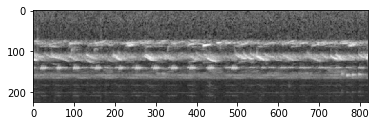

In [18]:
data_ = data_.to('cpu').detach().numpy().copy()
plt.figure()
plt.imshow(np.moveaxis(data_[0], 0, 2))

In [19]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)

In [ ]:

output_path = './output/01'

model = LitModule()

# most basic trainer, uses good defaults
trainer = pl.Trainer(
    max_epochs=10,
    default_root_dir=output_path,
    # use_amp=False,
)
trainer.fit(model, train_loader, valid_loader)

Using cache found in /home/user/.cache/torch/hub/zhanghang1989_ResNeSt_master
GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | encoder   | ResNet            | 28.6 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
28.6 M    Trainable params
0         Non-trainable params
28.6 M    Total params
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/d

/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
